# 1D Problem

One dimensional standard problem for the *Proposal for a micromagnetic standard problem for materials with Dzyaloshinskii-Moriya interaction* paper.

System:


    * A permalloy-like 1D wire of 100 nm x 1 nm x 1 nm (x,y,z)
    * Interactions: Exchange:                      13  pJ m**-1
                    DMI:                            3  mJ m**-2
                    Uniaxial Anisotropy along z:  0.4  MJ m**-3
                    Ms:                          0.86  A / m  

We will solve and simulate the system using interfacial ($C_{nv}$), bulk ($T$) and $D_{2d}$ DMI 

In [20]:
# System parameters
nm = 1e-9
L = 100 * nm      # sample length in nm
l = L / nm        # scale in nm

# Permalloy-like material (for testing purposes)
A = 13e-12
D = 3e-3
Ku = 0.4e6
Ms = 0.86e6

# Imports

In [21]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('lato_style.mplstyle')

import pandas as pd

# Finmag

In [22]:
data_Cnv = np.loadtxt('../sims/finmag/1D/1d_Cnv.dat')
data_T = np.loadtxt('../sims/finmag/1D/1d_T.dat')

# ODE

In [8]:
import scipy.integrate

In [9]:
# Use units in the nm scale
delta = (np.sqrt(A / Ku)) / nm
xi = (2 * A / D) / nm

# Set of differential equations for (u, v)
def ode_1d(theta, r, delta=1):
    return np.array([theta[1], 
                      np.cos(theta[0]) * np.sin(theta[0]) / delta ** 2
                      ])


# Define a function to solve the differential equation in the (0, l) range
# for any v(0) condition, u(0) is set to 1/xi
# The function returns the difference with respect to the desired solution at x=l
# The boundary conditions differ in sign for the interfacial and DMI cases
r_array = np.linspace(0, l, 100)

def solve_ode(a, sign=1):  
    # Impose the condition over the angle rather than its derivative
    solution, info = scipy.integrate.odeint(lambda t, r: ode_1d(t, r, delta=delta), 
                                            [np.arcsin(sign * delta / xi), a], r_array, full_output=True)
    # By inspection we found that the right extrema must be positive to match
    # the condition for the derivative
    return solution[:, 0][-1] - np.arcsin(-sign * delta / xi)

# Find the root from the differences:
guess_int = scipy.optimize.brentq(lambda a: solve_ode(a, sign=-1), 0., 0.2)
guess_bulk = scipy.optimize.brentq(lambda a: solve_ode(a, sign=1), -0.2, 0.)

print('Interfacial: ', guess_int)
print('Bulk: ', guess_bulk)

# Solve the system with the right condition at theta(L)
solution_int, info = scipy.integrate.odeint(lambda t, r: ode_1d(t, r, delta=delta), 
                                            [np.arcsin(-delta / xi), guess_int], r_array, full_output=True)
solution_bulk, info = scipy.integrate.odeint(lambda t, r: ode_1d(t, r, delta=delta), 
                                             [np.arcsin(delta / xi), guess_bulk], r_array, full_output=True)

Interfacial:  0.11538462445618079
Bulk:  -0.11538462445618079


# Comparison

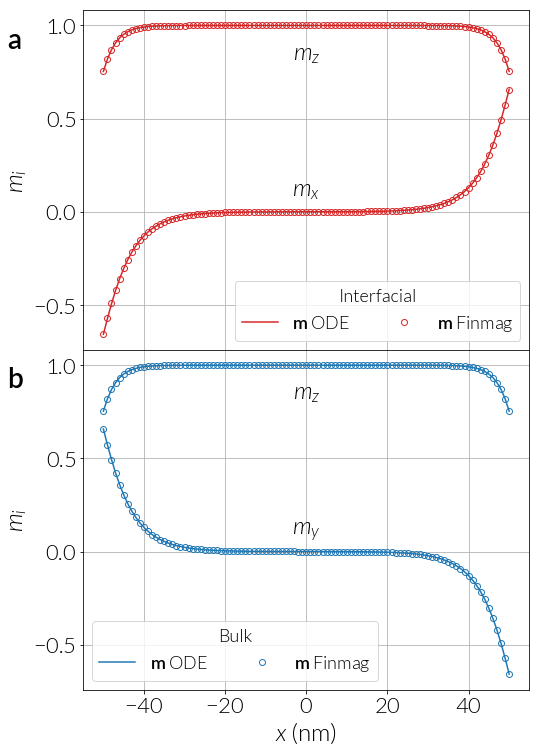

In [24]:
f, axs = plt.subplots(nrows=2, sharex=True, figsize=(8, 20/1.6))

# ODE solve:
axs[0].plot(r_array - l / 2, np.sin(solution_int[:, 0]), 'C3-', label=r'$\mathbf{m}$ ODE')
axs[0].plot(r_array - l / 2, np.cos(solution_int[:, 0]), 'C3-')

# Finmag interfacial DMI
axs[0].plot(data_Cnv[:, 0] - l / 2, data_Cnv[:, 1], 'C3o', label=r'$\mathbf{m}$ Finmag', 
         markerfacecolor='None', ms=6)
axs[0].plot(data_Cnv[:, 0] - l / 2, data_Cnv[:, 3], 'C3o', 
         markerfacecolor='None', ms=6)

leg = axs[0].legend(loc=0, ncol=2, fontsize=18)
leg.set_title('Interfacial', prop={'size':18})
axs[0].set_xlabel(r'$x$ (nm)')
axs[0].set_ylabel(r'$m_{i}$')
axs[0].grid()

axs[0].text(0.5, 0.9, r'$m_{z}$', horizontalalignment='center', verticalalignment='top', 
         transform=axs[0].transAxes)

axs[0].text(0.5, 0.5, r'$m_{x}$', horizontalalignment='center', verticalalignment='top', 
         transform=axs[0].transAxes)

axs[0].text(-0.17, 0.95, 'a', horizontalalignment='left', verticalalignment='top', 
         transform=axs[0].transAxes, fontweight='bold', fontsize=28)

# -----------------------------------------------------------------------------

# ODE solve:
axs[1].plot(r_array - l / 2, np.sin(solution_bulk[:, 0]), 'C0-', label=r'$\mathbf{m}$ ODE')
axs[1].plot(r_array - l / 2, np.cos(solution_bulk[:, 0]), 'C0-')

# Finmag interfacial DMI
axs[1].plot(data_T[:, 0] - l / 2, data_T[:, 2], 'C0o', label=r'$\mathbf{m}$ Finmag', 
         markerfacecolor='None', ms=6)
axs[1].plot(data_T[:, 0] - l / 2, data_T[:, 3], 'C0o', 
            markerfacecolor='None', ms=6)

leg = axs[1].legend(loc=0, ncol=2, fontsize=18)
leg.set_title('Bulk', prop={'size':18})
axs[1].set_xlabel(r'$x$ (nm)')
axs[1].set_ylabel(r'$m_{i}$')
axs[1].grid()

axs[1].text(0.5, 0.9, r'$m_{z}$', horizontalalignment='center', verticalalignment='top', 
         transform=axs[1].transAxes)
axs[1].text(0.5, 0.5, r'$m_{y}$', horizontalalignment='center', verticalalignment='top', 
         transform=axs[1].transAxes)

axs[1].text(-0.17, 0.95, 'b', horizontalalignment='left', verticalalignment='top', 
         transform=axs[1].transAxes, fontweight='bold', fontsize=28)

# -----------------------------------------------------------------------------

plt.subplots_adjust(hspace=0)
# plt.legend(ncol=2, loc='lower left', bbox_to_anchor=(0, 1.02, 1.0, 1),
#            mode='expand', borderaxespad=0.)

plt.savefig('../paper/result_1d_finmag.pdf', bbox_inches='tight')

Export the data from the figure:

In [31]:
!mkdir -p data

In [32]:
np.savetxt('data/result_1d_bulk_finmag.txt', np.column_stack((data_T[:, 0] - l / 2, data_T[:, 2])))
np.savetxt('data/result_1d_interfacial_finmag.txt', np.column_stack((data_Cnv[:, 0] - l / 2, data_Cnv[:, 2])))